# 3. Linear Neural Networks(1)

## 3.1 Linear Regression

(1) basis

* training dataset
* label(or target)
* feature(or covariates)

(2) Linear Model
$$\hat{y}=w_1x_1+w_dx_d+b.$$

(3) Loss Function
$$l^{(i)}(w, b)=1/2(\hat{y}^{(i)}-y^{(i)})^2.$$

$$L(w,b)=1/nΣ_{i=1}^{n}l^{(i)}(w, b)=1/nΣ_{i=1}^{n}1/2(w^Tx^{i}+b-y^{(i)})^2.$$

$$w^*, b^* = argmin_{w,b}L(w,b).$$

(4) Minibatch Stochastic Gradient Descent

* we initalize the values of the model parameters, typically at random
* we iteratively sample random minibatches from the data, updating the parameters in the direction of the negative gradient

$$w \leftarrow w - \frac{η}{|𝚩|}Σ_{i∈𝚩}∂_wl^{(i)}(w,b)=w-\frac{η}{|𝚩|}Σ_{i∈𝚩}x^{(i)}(w^Tx^{(i)}+b-y^{(i)},$$

$$b \leftarrow b - \frac{η}{|𝚩|}Σ_{i∈𝚩}∂_bl^{(i)}(w,b)=b-\frac{η}{|𝚩|}Σ_{i∈𝚩}(w^Tx^{(i)}+b-y^{(i)}).$$


## 3.1.2 Vectorization for Speed

In [ ]:
!pip install d2l==0.14.2

In [2]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [3]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [4]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
      self.times = []
      self.start()
    
    def start(self):
      """Start the timer."""
      self.tik = time.time()

    def stop(self):
      """Stop the timer and record the time in a list."""
      self.times.append(time.time() - self.tik)
      return self.times[-1]
    
    def avg(self):
      """Return the average time."""
      return sum(self.times) / len(self.times)
    
    def sum(self):
      """Return the sum of time."""
      return sum(self.times)
    
    def cumsum(self):
      """Return the accumulated time."""
      return np.array(self.times).cumsum().tolist()

In [5]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
  c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.11329 sec'

In [6]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00024 sec'

Normal Distribution

$$p(x)=\frac{1}{\sqrt{2πσ^2}}exp(-\frac{1}{2σ^2}(x-μ)^2).$$

In [7]:
def normal(x, mu, sigma):
  p = 1 / math.sqrt(2 * math.pi * sigma ** 2)
  return p * np.exp(-0.5 / sigma**2 * (x-mu)**2)

In [8]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

In [9]:
# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]

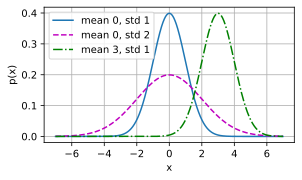

In [10]:
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel = 'x', ylabel='p(x)', figsize=(4.5, 2.5),
         legend = [f'mean {mu}, std {sigma}' for mu, sigma in params]
         )

MLE(Maximum Likelihood Estimator)

according to the principle of maximum likelihood, the best values of parameters **w** and b are those that maximize the likelihood of the entire dataset:

$$P(y|X)=∏_{i=1}^{n}p(y^{(i)}|x^{(i)})$$


For historical reasons, optimizations are more often expressed as minimization rather than maximization. So, without changing anything we can minimize the negative log-likelihood -logP(y|X). Working out the mathematics gives us:
$$-logP(y|X)=Σ_{i=1}^n\frac{1}{2}log(2πσ^2)+\frac{1}{2σ^2}(y^{(i)}-w^Tx^{(i)}-b)^2.$$

## Summary
* Key ingredients in a machine learning model are training data, a loss function, an optimization algorithm, and quite obviously, the model itself.
* Vectorizing makes everything better (mostly math) and faster(mostly code)
* Minimizing an objective function and peforming maximum likelihood estimation can mean the same thing.
* Linear regression models are neural networks, too.

## 3.2 Linear Regression Implementation From Scratch
* 1. generating dataset
* 2. reading the dataset
* 3. initializing model parameters
* 4. defining the model
* 5. defining the loss function
* 6. defining the optimization algorithm
* 7. training

In [11]:
import random

In [12]:
# generating dataset
def synthetic_data(w, b, num_examples):
  """Generate y = Xw + b + noise."""
  X = torch.normal(0, 1, (num_examples, len(w)))
  y = torch.matmul(X, w) + b
  y += torch.normal(0, 0.01, y.shape)
  return X, y.reshape((-1, 1))

In [13]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [14]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.4105, -0.1833]) 
label: tensor([4.0055])


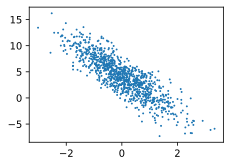

In [15]:
d2l.set_figsize()
# The simicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [16]:
# reading the dataset
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  # the examples are read at random, in no particular order
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(
        indices[i: min(i+batch_size, num_examples)]
    )
    yield features[batch_indices], labels[batch_indices]

In [17]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
  print(X, '\n',y)
  break

tensor([[-0.9573, -2.0292],
        [-1.1070,  0.7368],
        [ 0.7688, -0.5905],
        [-0.4613,  1.1296],
        [ 1.0541,  0.3551],
        [ 0.0126, -1.1068],
        [-0.2491,  0.1526],
        [ 0.4707,  0.8906],
        [-0.1686,  0.7860],
        [-0.7434, -0.3037]]) 
 tensor([[ 9.1868],
        [-0.5083],
        [ 7.7504],
        [-0.5585],
        [ 5.0852],
        [ 7.9787],
        [ 3.1670],
        [ 2.1010],
        [ 1.1844],
        [ 3.7541]])


In [18]:
# initializing model parameters
w = torch.normal(0, 0.01, size = (2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [19]:
# defining the model
def linreg(X, w, b):
  """The linear regression model."""
  return torch.matmul(X, w) + b

In [20]:
# defining the loss function
def squared_loss(y_hat, y):
  """Squared loss."""
  return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [21]:
# defining the optimization algorithm
def sgd(params, lr, batch_size):
  """Minibatch stochastic gradient descent."""
  with torch.no_grad():
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()

Training following loop:
* Initialize parameters (**w**, b)
* Repeat until done
  
  1) Compute gradient
$$g ← ∂_{(w,b)}\frac{1}{|𝚩|}Σ_{i∈𝚩}l(x^{(i)}, y^{(i)}, w, b) $$
  
  2) Update parameters
$$(w, b) ← (w, b) - ηg$$

In [22]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [23]:
for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y) # Minibatch loss in `X` and `Y`
    # Compute gradient on `l` with respect to [`w`, `b`]
    l.sum().backward()
    sgd([w, b], lr, batch_size) # Update parameters using their gradient
  with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.050636
epoch 2, loss 0.000220
epoch 3, loss 0.000049


In [24]:
print(f'error in estimating w : {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b : {true_b - b}')

error in estimating w : tensor([ 0.0006, -0.0003], grad_fn=<SubBackward0>)
error in estimating b : tensor([0.0008], grad_fn=<RsubBackward1>)


## Summary
* We saw how a deep network can be implemented and optimized from scratch, using just tensors and auto differentiation, without any need for defining layers or fancy optimizers.
* This section only scratches the surface of what is possible. In the following sections, we will describe additional models based on the concepts that we have just introduced and learn how to implement them more concisely.

## 3.3 Concise Implementation of Linear Regression

In [25]:
# generating the dataset
from torch.utils import data

In [26]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [27]:
# reading the dataset
def load_array(data_arrays, batch_size, is_train=True):
  """Construct a PyTorch data iterator."""
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [28]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [30]:
next(iter(data_iter))

[tensor([[-0.5939, -1.1987],
         [ 0.7884, -0.0274],
         [ 0.3320, -1.2580],
         [-0.9125, -1.0556],
         [-0.6750, -0.1571],
         [-0.0434,  1.2953],
         [ 0.4169, -1.3760],
         [-0.8714,  0.0673],
         [ 0.7906,  0.1946],
         [-0.2402,  0.0730]]), tensor([[ 7.0991],
         [ 5.8782],
         [ 9.1370],
         [ 5.9637],
         [ 3.3786],
         [-0.2712],
         [ 9.7110],
         [ 2.2267],
         [ 5.1132],
         [ 3.4700]])]

In [31]:
# defining the model
# `nn` is an abbreviation for neural networks
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [32]:
# initializing model parameters
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [33]:
# defining the loss function
loss = nn.MSELoss() # MSELoss class computes the mean squared error. By default it returns the average loss over examples

In [34]:
# defining the optimization algorithm
trainer = torch.optim.SGD(net.parameters(), lr = 0.03)

In [36]:
# training
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([ 2.0112, -3.3883])
error in estimating b: tensor([4.2000])


## Summary
* Using PyTorch's high-level APIs, we can implement models much more concisely.
* In PyTorch, the data module provides tools for data processing, the nn module defines a large number of neural network layers and common loss functions.
* We can initialize the parameters by replacing their values with methods ending with _.